## Set up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

/Users/luiz/Documents/Projects/ieor4578_project2/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import dataset

In [3]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Date,FuzzedDescription,UnitsSold,PricePerUnitPounds,RevenuePounds
0,2009-12-01,12 pencils small tube red spotty,45,0.76,34.20
1,2009-12-01,12 pencils tall tube posy,69,1.08,74.52
2,2009-12-01,12 pencils tall tube woodland,4,1.27,5.08
3,2009-12-01,3 stripey mice feltcraft,9,2.54,22.86
4,2009-12-01,6 ribbons rustic charm,27,2.67,72.09
...,...,...,...,...,...
48125,2010-12-09,wooden picture frame white finish,22,2.55,56.10
48126,2010-12-09,wooden school colouring set,13,2.50,32.50
48127,2010-12-09,woodland charlotte bag,5,1.25,6.25
48128,2010-12-09,world war 2 gliders asstd designs,52,0.36,18.72


<Axes: xlabel='Date'>

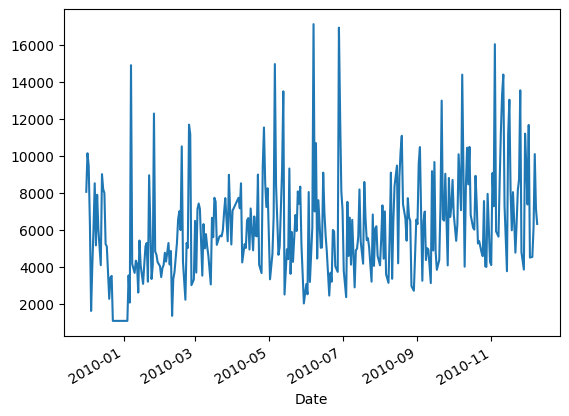

In [18]:
online_retail_df.groupby('Date')['UnitsSold'].sum().plot()

In [40]:
expected_dates = pd.date_range(start=online_retail_df["Date"].min(), end=online_retail_df["Date"].max(), freq="D")
missing_dates = expected_dates.difference(online_retail_df['Date'].unique())
missing_dates

DatetimeIndex(['2009-12-12', '2009-12-19', '2009-12-24', '2009-12-25',
               '2009-12-26', '2009-12-27', '2009-12-28', '2009-12-29',
               '2009-12-30', '2009-12-31', '2010-01-01', '2010-01-02',
               '2010-01-03', '2010-01-09', '2010-01-16', '2010-01-23',
               '2010-01-30', '2010-02-06', '2010-02-13', '2010-02-20',
               '2010-02-27', '2010-03-06', '2010-03-13', '2010-03-20',
               '2010-03-27', '2010-04-02', '2010-04-03', '2010-04-04',
               '2010-04-05', '2010-04-10', '2010-04-17', '2010-04-24',
               '2010-05-01', '2010-05-03', '2010-05-08', '2010-05-15',
               '2010-05-22', '2010-05-29', '2010-05-31', '2010-06-05',
               '2010-06-12', '2010-06-19', '2010-06-26', '2010-07-03',
               '2010-07-10', '2010-07-17', '2010-07-24', '2010-07-31',
               '2010-08-07', '2010-08-14', '2010-08-21', '2010-08-28',
               '2010-08-30', '2010-09-04', '2010-09-11', '2010-09-18',
      

In [48]:
all_products = online_retail_df['FuzzedDescription'].unique()
full_index = pd.MultiIndex.from_product(
    [all_products, expected_dates],
    names=['FuzzedDescription', 'Date']
)

complete_df = online_retail_df.set_index(["FuzzedDescription", "Date"]).reindex(full_index).reset_index().fillna(0)

<Axes: xlabel='Date'>

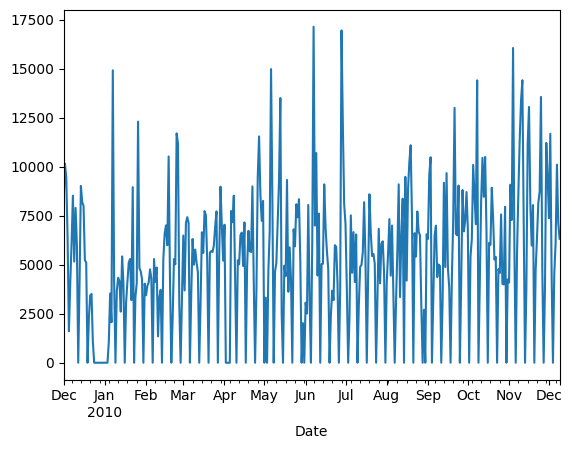

In [49]:
complete_df.groupby('Date')['UnitsSold'].sum().plot()

## Prepare the dataset

In [4]:
# Using the pivoting process so that every product has the same
# number of timestamps.
pivoted_data = online_retail_df.pivot(index='Date', columns='FuzzedDescription', values='UnitsSold')
pivoted_data = pivoted_data.fillna(0)
pivoted_data

FuzzedDescription,12 pencils small tube red spotty,12 pencils tall tube posy,12 pencils tall tube woodland,3 stripey mice feltcraft,6 ribbons rustic charm,60 teatime fairy cake cases,72 sweetheart fairy cake cases,airline bag vintage jet set red,antique silver tea glass etched,assorted colour bird ornament,...,wood black board ant white finish,wood s3 cabinet ant white finish,wooden box of dominoes,wooden frame antique white,wooden happy birthday garland,wooden picture frame white finish,wooden school colouring set,woodland charlotte bag,world war 2 gliders asstd designs,zinc metal heart decoration
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-01,45.0,69.0,4.0,9.0,27.0,173.0,50.0,0.0,210.0,1272.0,...,0.0,5.0,18.0,38.0,0.0,30.0,0.0,34.0,48.0,66.0
2009-12-02,87.0,87.0,21.0,19.0,7.0,159.0,229.0,0.0,122.0,121.0,...,0.0,10.0,59.0,40.0,0.0,83.0,0.0,20.0,435.0,254.0
2009-12-03,34.0,116.0,13.0,101.0,3.0,201.0,83.0,0.0,158.0,312.0,...,0.0,26.0,58.0,46.0,21.0,48.0,0.0,10.0,56.0,104.0
2009-12-04,84.0,160.0,25.0,7.0,2.0,99.0,3.0,0.0,56.0,258.0,...,0.0,10.0,13.0,19.0,43.0,8.0,0.0,14.0,144.0,65.0
2009-12-05,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,24.0,...,0.0,26.0,0.0,48.0,0.0,54.0,0.0,0.0,48.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-05,151.0,6.0,15.0,4.0,49.0,9.0,19.0,8.0,148.0,129.0,...,49.0,3.0,20.0,30.0,13.0,39.0,17.0,42.0,96.0,34.0
2010-12-06,135.0,4.0,17.0,36.0,38.0,57.0,1.0,10.0,390.0,130.0,...,33.0,7.0,230.0,24.0,8.0,16.0,20.0,15.0,8.0,33.0
2010-12-07,20.0,15.0,9.0,9.0,37.0,30.0,28.0,10.0,162.0,271.0,...,1083.0,8.0,22.0,32.0,3.0,20.0,3.0,127.0,50.0,51.0


In [5]:
# The PyTorch TFT expects the time axis to be a 
# natural number, not datetime, so we format the
# data appropriately.
formatted_df = pivoted_data.reset_index().melt(id_vars="Date", 
                                               var_name="ProductId", 
                                               value_name="UnitsSold")
formatted_df = formatted_df.sort_values(['Date', 'ProductId'])
formatted_df.loc[:,'TimeIdx'] = formatted_df.groupby("ProductId").cumcount()
formatted_df = formatted_df[['TimeIdx', 'ProductId', 'UnitsSold']].reset_index()
formatted_df

,index,TimeIdx,ProductId,UnitsSold
0,0,0,12 pencils small tube red spotty,45.0
1,307,0,12 pencils tall tube posy,69.0
2,614,0,12 pencils tall tube woodland,4.0
3,921,0,3 stripey mice feltcraft,9.0
4,1228,0,6 ribbons rustic charm,27.0
...,...,...,...,...
60167,58943,306,wooden picture frame white finish,22.0
60168,59250,306,wooden school colouring set,13.0
60169,59557,306,woodland charlotte bag,5.0
60170,59864,306,world war 2 gliders asstd designs,52.0


In [6]:
training_cutoff = formatted_df['TimeIdx'].max() - 30  # Leave 30 days for validation
min_prediction_length = 1  # day
max_prediction_length = 30  # days
min_encoder_length = 30  # days
max_encoder_length = 30  # days

training_dataset = TimeSeriesDataSet(
    formatted_df[lambda x: x['TimeIdx'] <= training_cutoff],
    time_idx='TimeIdx',
    target='UnitsSold',
    group_ids=['ProductId'],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['ProductId'],
    static_reals=[],
    time_varying_known_categoricals=[],
     # group of categorical variables can be treated as one variable
    variable_groups={},
    time_varying_known_reals=['TimeIdx'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['UnitsSold'],
    target_normalizer=GroupNormalizer(
        groups=['ProductId'], transformation='softplus'),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Create a validation set (predict=True) which means to predict the last
# max_prediction_length points in time for each series.
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    formatted_df,
    predict=True,
    stop_randomization=True,
)

# Create dataloaders for the model
batch_size = 32
train_dataloader = training_dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation_dataset.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

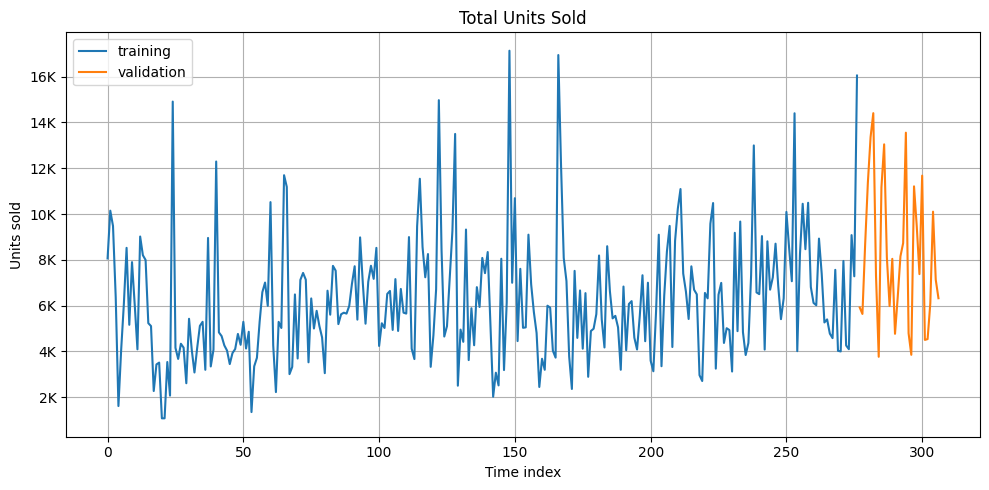

In [7]:
training_total = (
    formatted_df[lambda x: x['TimeIdx'] <= training_cutoff]
    .groupby('TimeIdx')['UnitsSold']
    .sum()
    .sort_index())
validation_total = (
    formatted_df[lambda x: x['TimeIdx'] > training_cutoff]
    .groupby('TimeIdx')['UnitsSold']
    .sum()
    .sort_index())

fig, ax = plt.subplots(figsize=(10,5))

training_total.plot(ax=ax, label='training')
validation_total.plot(ax=ax, label='validation')

ax.set_title('Total Units Sold')
ax.set_xlabel('Time index')
ax.set_ylabel('Units sold')
ax.legend()
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Baseline model

In [8]:
# Calculate a baseline mean absolute percentage error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(
    val_dataloader,
    return_y=True,
    return_index=True,
)
MAPE()(baseline_predictions.output, baseline_predictions.y)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(3.1129e+08, device='mps:0')

In [9]:
# Extract predictions and actuals
index = baseline_predictions.index['ProductId']

y_pred = pd.DataFrame(baseline_predictions.output.cpu().numpy(), index=index).reset_index()
y_true = pd.DataFrame(baseline_predictions.y[0].cpu().numpy(), index=index).reset_index()

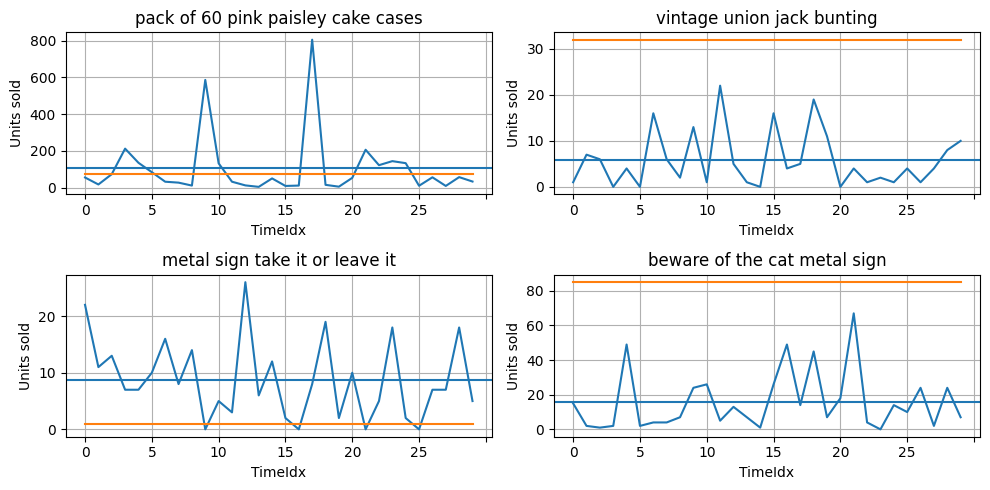

In [10]:
products = np.random.choice(y_pred['ProductId'], size=4)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

for ax, product in zip(axs.flatten(), products):
    y_true.query(f'ProductId == "{product}"').drop(columns=['ProductId']).T.plot(ax=ax)
    ax.axhline(y_true.query(f'ProductId == "{product}"').drop(columns=['ProductId']).T.mean().values)
    y_pred.query(f'ProductId == "{product}"').drop(columns=['ProductId']).T.plot(ax=ax)
    ax.grid(True, which='both')
    ax.set_title(product)
    ax.set_xlabel('TimeIdx')
    ax.set_ylabel('Units sold')
    ax.legend().remove()

plt.tight_layout()
plt.show()

## Train model

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 8.4k


Finding best initial lr: 100%|████████████████| 100/100 [00:05<00:00, 18.55it/s]
Learning rate set to 2.137962089502232e-05
Restoring states from the checkpoint path at /Users/luiz/Documents/Projects/ieor4578_project2/notebooks/tft/.lr_find_5208373b-3b3d-4ebf-bfb6-93ab8f787efa.ckpt
Restored all states from the checkpoint at /Users/luiz/Documents/Projects/ieor4578_project2/notebooks/tft/.lr_find_5208373b-3b3d-4ebf-bfb6-93ab8f787efa.ckpt


suggested learning rate: 2.137962089502232e-05


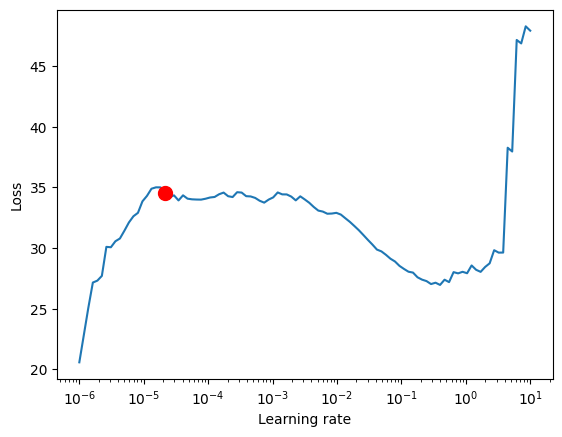

In [11]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,
    # number of attention heads
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="ranger",
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [12]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.9k


In [13]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.1 K  | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Epoch 0: 100%|██| 50/50 [00:02<00:00, 16.72it/s, v_num=1, train_loss_step=15.40]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00,  7.11it/s]
Epoch 1: 100%|█| 50/50 [00:03<00:00, 15.76it/s, v_num=1, train_loss_step=17.90, 
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00,  7.24it/s]
Epoch 2: 100%|█| 50/50 [00:02<00:00, 17.19it/s, v_num=1, train_loss_step=13.90, 
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00,  7.29it/s]
Epoch 3: 100%|█| 50/50 [00:02<00:00, 16.95it/s, v_num=1, train_loss_step=15.40, 
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00,  7.47it/s]
Epoch 4: 100%|█| 50/50 [00:0

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█| 50/50 [00:03<00:00, 14.04it/s, v_num=1, train_loss_step=12.70,


In [15]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-04-23 19:08:50,870] A new study created in memory with name: no-name-349088fe-e6fe-4c65-a6fc-c925bf9f8873
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

Detected KeyboardInterrupt, attempting graceful shutdown ...
[W 2025-04-23 19:14:22,263] Trial 0 failed with parameters: {'gradient_clip_val': 0.07090307830102122, 'hidden_size': 10, 'dropout': 0.22160850635696655, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0016741889281583343} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "/Users/luiz/Documents/Projects/ieor4578_project2/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/Users/luiz/Documents/Projects/ieor4578_project2/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/trainer.py", line 599, in _fit

NameError: name 'exit' is not defined